In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import utils
from functools import partial
from utils import KernelFunction, KernelEnvironment
from utils import plot_kernel_function, compare_kernels
from gflownet import GFlowNet 

In [2]:
import torch.nn.functional as F
from torch.distributions import Categorical
import torch

In [3]:
from utils import ForwardPolicy, BackwardPolicy
import random

In [4]:
global reward_calls
reward_calls = 0
def log_likelihood_reward(X, Y, env: 'KernelEnvironment'):
    """
    Computes the log marginal likelihood of each kernel in the environment
    given the data (X, Y).
    """
    global reward_calls
    reward_calls += env.batch_size
    rewards = []
    for k in env.state: 
        log_likelihood = utils.evaluate_likelihood(k, X, Y)
        #print(np.log(1 + np.exp(-0.5 * (log_likelihood - 5))))
        reward = 1 / np.log(1 + np.exp(-0.05 * (log_likelihood))) 
        if reward < 1e-10:
            print("Warning: Reward is too small, setting to 1e-10")
            reward = 1e-10
        rewards.append(reward if log_likelihood is not None else 1e-10)
        #print(reward, log_likelihood)
        #rewards.append(log_likelihood**(3/2) if log_likelihood is not None else 1e-10)
    return torch.tensor(rewards, dtype=torch.float32) 

def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

In [5]:
def randomize_hyperparameters(kernel: KernelFunction):
    """
    Recursively traverses a KernelFunction object and randomly modifies the
    hyperparameters of its base components in a reasonable range.
    
    Args:
        kernel (KernelFunction): The kernel object to modify in-place.
    """
    # Base case: If this is a base kernel (like RBF, Linear), modify its params.
    # A base kernel has no children.
    if not kernel.children:
        if kernel.hyperparams:
            print(f"  -> Randomizing '{kernel.name}' params...")
            for param, value in kernel.hyperparams.items():
                # Define a scaling factor to adjust the parameter.
                # e.g., random.uniform(0.5, 1.5) will change the value
                # by -50% to +50% of its original value.
                scale_factor = random.uniform(0.5, 1.5)
                new_value = value * scale_factor
                
                # Update the hyperparameter in the dictionary, rounding for neatness
                kernel.hyperparams[param] = round(new_value, 3)

    # Recursive step: If this is a composite kernel (Sum, Product),
    # call this function on each of its children.
    else:
        for child in kernel.children:
            randomize_hyperparameters(child)

def create_random_kernel():
    """
    Creates a random kernel function.
    """
    # Create a series of actions from a uniform distribution
    env = KernelEnvironment(
        batch_size=1,
        max_trajectory_length=4,
        log_reward=log_likelihood_reward
    )
    n = env.action_space_size  
    logits = torch.ones(n) 
   

    for i in range(4):
        if i == 0:
            #prevent the first action from being a stop (-1)
            logits[-1] = -torch.inf
            dist = Categorical(logits=logits)
            actions = dist.sample((1,))  # Creates a 1D tensor of shape [1]
        else:
            logits[-1] = 1
            dist = Categorical(logits=logits)
            actions = dist.sample((1,)) # Creates a 1D tensor of shape [1]

        env.apply(actions)
    
    KFn = env.state[0]
    randomize_hyperparameters(KFn)
    
    return KFn


  -> Randomizing 'Constant' params...
  -> Randomizing 'RBF' params...
  -> Randomizing 'Linear' params...
True Kernel: ((Constant({'variance': 0.686}) + RBF({'lengthscale': 1.213, 'variance': 1.351})) + Linear({'variances': 1.043})) Log Marginal Likelihood: 35.03460178443015


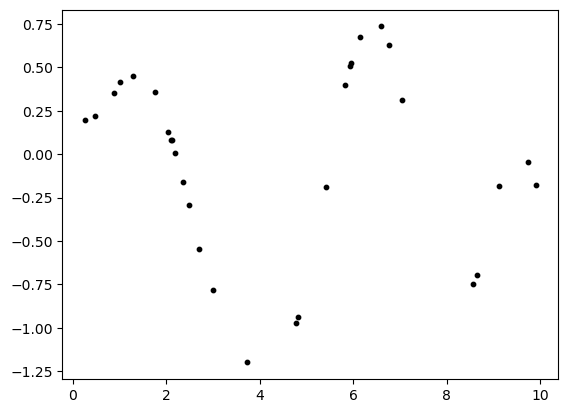

In [6]:
ll = -1
while ll < 0:
    true_kernel = create_random_kernel()
    X, Y, true_kernel_str = utils.generate_gp_data(true_kernel, input_dim=1, n_points=30, noise_var=1e-4)
    X_test, Y_test, _ = utils.generate_gp_data(true_kernel, input_dim=1, n_points=50, noise_var=1e-4)
    ll = utils.evaluate_likelihood(true_kernel, X, Y, runtime=False)

print("True Kernel:", true_kernel_str, "Log Marginal Likelihood:", utils.evaluate_likelihood(true_kernel, X, Y, runtime=False))

plt.scatter(X, Y, color='black', s=10, label='Data Points')

In [7]:
candidate_kernel = create_random_kernel()
print("True Kernel:", candidate_kernel, "Log Marginal Likelihood:", utils.evaluate_likelihood(candidate_kernel, X, Y, runtime=False))

  -> Randomizing 'Periodic' params...
True Kernel: Periodic({'period': 1.296, 'variance': 0.755, 'lengthscale': 0.921}) Log Marginal Likelihood: -25.10108565791738


In [11]:
from utils import train

epochs = 1000
BATCH_SIZE = 64
MAX_LEN = 4
lr = 1e-3

log_reward_fn = partial(log_likelihood_reward, X, Y)
env = create_env()

forward_model = ForwardPolicy(input_dim=MAX_LEN, output_dim=env.action_space_size, epsilon=0.5)
backward_model = BackwardPolicy()
criterion = 'tb'

In [12]:
gflownet = GFlowNet(
    forward_flow=forward_model, 
    backward_flow=backward_model, 
    criterion=criterion
)


train(
    gflownet=gflownet,
    create_env=create_env,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    lr=lr,
    min_eps=1e-2,#should have clamp g set
    clamp_g= .1,
    use_scheduler=True
)

100%|██████████| 1000/1000 [00:19<00:00, 50.14it/s, loss=0.883]


(GFlowNet(
   (forward_flow): ForwardPolicy(
     (net): Sequential(
       (0): Linear(in_features=4, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=10, bias=True)
     )
   )
 ),
 [78.58422088623047,
  51.8980712890625,
  44.37074279785156,
  34.98078918457031,
  28.313447952270508,
  18.2545166015625,
  11.803812026977539,
  9.001080513000488,
  6.356296062469482,
  4.056729793548584,
  5.2501373291015625,
  6.260568618774414,
  7.6848626136779785,
  8.631447792053223,
  7.205678462982178,
  5.7023138999938965,
  4.556643962860107,
  4.2397589683532715,
  4.537820816040039,
  4.151886940002441,
  3.34759521484375,
  6.014739036560059,
  6.063808441162109,
  4.7485246658325195,
  2.9160988330841064,
  5.2107977867126465,
  3.891636371612549,
  3.4441027641296387,
  4.527315616607666,
  4.12436580657959,
  4.539187908172607,
  4.708052158355713,
  5.50173

In [15]:
# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)

# Expect to see kernels with high log likelihood
for i, kernel in enumerate(final_batch_ll.state):
    print(f"Sample {i+1}: {kernel}, Reward: {1 / np.log(1 + np.exp(-0.05 * (utils.evaluate_likelihood(kernel, X, Y))))}, Log Likelihood: {utils.evaluate_likelihood(kernel, X_test, Y_test):.4f}")


 Sampling 25 kernels from the trained model...
Sample 1: ((Linear({'variances': 1.0}) + Constant({'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 6.64735084133925, Log Likelihood: 36.3612
Sample 2: ((Linear({'variances': 1.0}) + Linear({'variances': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 6.04883332334872, Log Likelihood: 34.3213
Sample 3: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Constant({'variance': 1.0})) + Linear({'variances': 1.0})), Reward: 6.64735084136346, Log Likelihood: 36.3612
Sample 4: ((Constant({'variance': 1.0}) + Constant({'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 6.792363332147573, Log Likelihood: 36.8257
Sample 5: ((Constant({'variance': 1.0}) * Linear({'variances': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 6.0662502544702885, Log Likelihood: 34.3837
Sample 6: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Constant({'variance': 1.0})) + RBF({'lengthscale': 1.0, '